# Long Period Fiber Gratings Spectral Fitting
## Bayesian Analysis proof of concept
##### Bernardo Santos Dias - July 2020
***

### 1. Curve fitting vs. Bayesian approach

In this notebook we perform a Bayesian Analysis of spectral fitting of a Long Period Fiber Grating. Here we have two different possible approaches:

#### - **Normal Python curve fitting methods** 
Given a specific function that works as our model for fitting, we can call Pythons scipy.optimize.curve_fit to find our models best parameters (generally using Levenberg-Marquardt or Trust Region Reflective algorithms). This has proven to lead to some mistakes, mostly in the amplitude parameter. A way to compensate for these types of errors is to bound the parameters, which would need not too tight so that there is no risk of the value falling out of the interval and not too large so that it converges on a wrong value.

**Advantages**: 

- Very fast method;

- Methods already available in Pythons modules;

**Disadvantages**: 

- Prone to errors in automatic curve fitting;

- Bounds generate an uniforme prior over the interval, giving equal probability distributions;

- Not easy to incorporate past inference.
    
#### - **Bayesian approach** 
Given our model and our data we can calculate the joint probability distibution for our parameters using appropriate priors, via Bayes Theorem. With this joint probability we can marginalize it to determine the probability distribution of each parameter. The best fit will be calculated via an estimator (mean, median or mode) for each parameter. 

**Advantages**: 

- Allows for easy incorporation of previous information obtained in the fabrication of the LPG;

- Allows for easy incorporation of previous measurements, providing self regulation of the parameters;

- The priors are actual probability distributions and not just uniform over the parameter space;

- For each parameter we have a probability distribution and not just a number, which can be useful when trying to undestand the different processes tha fiber has suffered.

**Disadvantages**: 

- Slower than curve fitting methods (especially is Markov Chain Monte Carlo is used);


### 2. Model

Here we consider a model of a Lorentzian function:

$$L(x, x_0, \gamma, A, C) = C - A \frac{\gamma^2}{(x-x_0)^2 + \gamma^2}$$

In which the parameters are the following:
- $x_0$: Wavelength corresponding to the transmission minimum
- $\gamma$: Half Width at Half Maximum
- $A$: Amplitude
- $C$: Offset

This model was considered because of previous work done, in which it was determined that from a Gaussian, Lorentzian or Voigt profile fittings, the Lorentzian was the one that best adapted itself to the data collected from the LPG spectrum analysis in an OSA. 

### 2. Fitting Method for Bayesian method

Our objective is to find the better fitting parameters considering this Lorentzian model. Considering a parameter vector $\vec{X} = (x_0, \gamma, A, C)^T$ we have (via Bayes Theorem):

$$p(\vec{X}|D, L, I) = \frac{p(\vec{X}|L,I)p(D|L, \vec{X},I)}{p(D|L,I)}$$

Where $p(\vec{X}|D, L, I)$ is the joint probability distribution of our model parameters, $p(\vec{X}|L,I)$ is our prior distributions for our parameters, $p(D|L, \vec{X},I)$ is our data likelihood considering the Lorentzian model $L$ and $p(D|L,I)$ is a normalization constant (obtained by integrating over all parameters). 

The marginal distribution for each parameter is calculated via:
$$p(X_j|D, L, I) = \prod_{i\neq j}\int p(X_i|L,I)p(D|L,X_i,I) dX_i$$

In our case for each parameter we have to perform a 3-dim integral, which could be very time consuming. Given this problem, we will try to implement a Markov-Chain Monte Carlo to estimate each of the marginal probability distributions.

##### Markov Chain Monte Carlo (MCMC) Integration

The algorithm used to obtain the samples of our parameters is a regular Metropolis-Hastings algorithm:

- Set $t=0$ and select an initial value $\vec{X_0}  = (x_0, \gamma_0, A_0, C_0)^T$ for our parameters;
- Repeat the following cycle for M iterations:

    - Set $t=t+1$;

    - Obtain a new sample from normal distributions $X_i '∼ N(X_{i_{t-1}},σ)$;

    - Calculate the Metropolis ratio, defined as:

        $$r=\frac{p(X_i'|D,L,I)}{p(X_{i_{t-1}}|D,L,I)}=\frac{p(X_i'|L,I)}{p(X_{i_{t-1}}|L,I)}\frac{p(D|L,X_i',I)}{p(D|L,X_{i_{t-1}},I)}$$
        
    - Take a sample from a uniform distribution $U\sim U(0,1)$;

    - If $r≥U$, accept the new values and set $\vec{X_t} = \vec{X}'$, otherwise reject the new values and set $\vec{X_t} = \vec{X_{t-1}}$.
    
In this notebook we have not explored the parameter space of our model, so our priors $p(X_i|L,I)$ will mostly be uniform over appropriate ranges. Studying the fabrication methods of LPG's could provide useful information regarding these probability distributions.

Another important thing to note is that in this notebook we will run our MCMC for a large number of iterations (over 1E6). This will be very slow and not always necessary, but will serve as a proof of concept.

We will import data collected by variation of Temperature, Strain and Refractive Index in LPG's, and adapt a single function to random sampled data points in a specific range. In another notebook this will be done as as interative process.

### Temperature Variation Data

We start by importing our temperature variation data and defining the functions we will use in the analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scpstats
import scipy.optimize as opt
import scipy.signal as signal
import glob
%matplotlib inline

In [121]:
def L(x, C,A, gamma, x0):
    return C - A  * gamma**2 / ((x-x0)**2 + gamma**2)
    
def likelihood(lamb ,data, Y):
    N = len(data)
    spectre = L(lamb, *Y)
    soma = np.sum((data - spectre)**2)
    like = (2*np.pi)**(-N/2) * sigma**(-N) * np.exp(-1/(2*sigma**2) * soma)
    return like

def MChain(initial, data, iterations):
    sampler = np.zeros((iterations, len(initial)))
    sampler[0] = initial
    per = 10
    for t in range(1, iterations):
        #Percentage done
        if int((t / iterations)*100) == per:
            print(str(per) + '% Done.')
            per += 10
             
        Y = np.zeros(len(initial))
        control = 0
        
        #Get new sample
        for i in range(len(initial)):
            Y[i] = np.random.normal(sampler[t-1, i], sigma_n, 1)[0]
            if Y[i] > limits[1][i] or Y[i] < limits[0][i]: 
                r = 0
                control = 1
                
        #Metropolis Ratio
        if control == 0:
            prior = (scpstats.norm.pdf(Y[1],28,1) * scpstats.norm.pdf(Y[2],2,.1) /
            (scpstats.norm.pdf(sampler[t-1][1],28,1) * scpstats.norm.pdf(sampler[t-1][2],2,.1)))
            #r =  * likelihood(lamb, data, Y) / (scpstats.norm.pdf(sampler[t-1][1],10,2) * likelihood(lamb, data, sampler[t-1]))
            r = prior * likelihood(lamb, data, Y) / likelihood(lamb, data, sampler[t-1])
        
        #Acceptance/Rejection
        U = np.random.uniform(0,1,1)[0]
        
        if r >= U: 
            sampler[t] = Y
        else: 
            sampler[t] = sampler[t-1]

        t += 1
    print('100% Done.')
    return sampler

def random_sampler(data, num):
    for i in [data]:
        for j in i.columns:
            arr = np.array(i[j])
            N=len(arr)
            #N = len(arr[:int(2/3 * len(arr))])
            rand = np.random.rand(3)
            y = np.zeros((len(rand), num))
            x = np.zeros((len(rand), num))
            for k in range(3):
                rand[k] = int((N/3 - num) * (k + rand[k]))
                y[k] = arr[int(rand[k]):int(rand[k]) + num]
                x[k] = i.index.values[int(rand[k]):int(rand[k]) + num]
            x = np.concatenate(x, axis = None)
            y = np.concatenate(y, axis = None)
    return x, y, i.index.values, arr

In [3]:
data_Temp = pd.read_csv('TEMP_STEPS/W0000.CSV', header = None, skiprows = 29)
data_Temp.columns=['Wavelength','Temp00']
data_Temp.set_index('Wavelength', inplace = True, drop = True)

Now we can plot our imported data and take a random sample from it in the different intervals. Given the data we will also define our initial guesses that will be fed to both the curve fitting methods and the MCMC defined above.

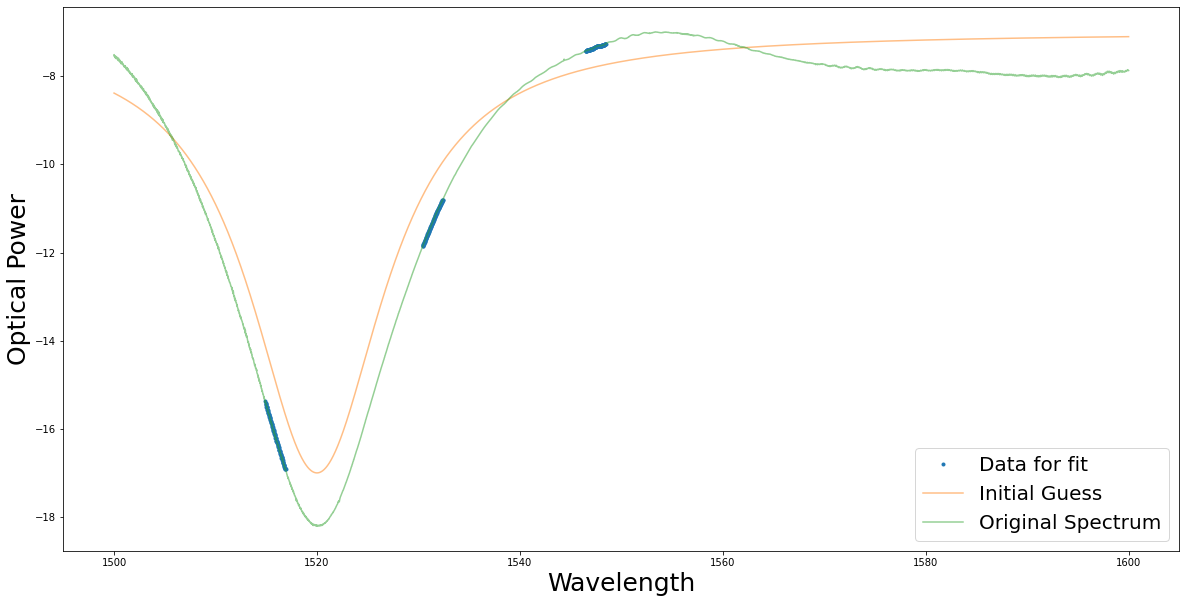

In [23]:
lamb, data, lamb_complete, data_complete = random_sampler(data_Temp, 100)

#Initial Guesses and limits for both methods
param = [-7,10,8,1520] #Offset, Amplitude, HWHM, Lambda
limits = [[-12,5,0,1510],[-4,20,20,1530]]

plt.figure(figsize=(20,10))
plt.plot(lamb, data, '.', label = 'Data for fit')
plt.plot(lamb_complete, L(lamb_complete, *param),alpha = 0.5, label = 'Initial Guess')
plt.plot(lamb_complete, data_complete,alpha = 0.5, label = 'Original Spectrum')
plt.xlabel('Wavelength', fontsize = 25)
plt.ylabel('Optical Power', fontsize = 25)
plt.legend(fontsize = 20)

Now we run our Markov Chain Monte Carlo with a large number of iterations and visualize the marginal probability distributions for our parameters. 

In [28]:
sigma = 1
sigma_n = 1
samples = MChain(param, data, 1000000)

10% Done.
20% Done.
30% Done.
40% Done.
50% Done.
60% Done.
70% Done.
80% Done.
90% Done.
100% Done.


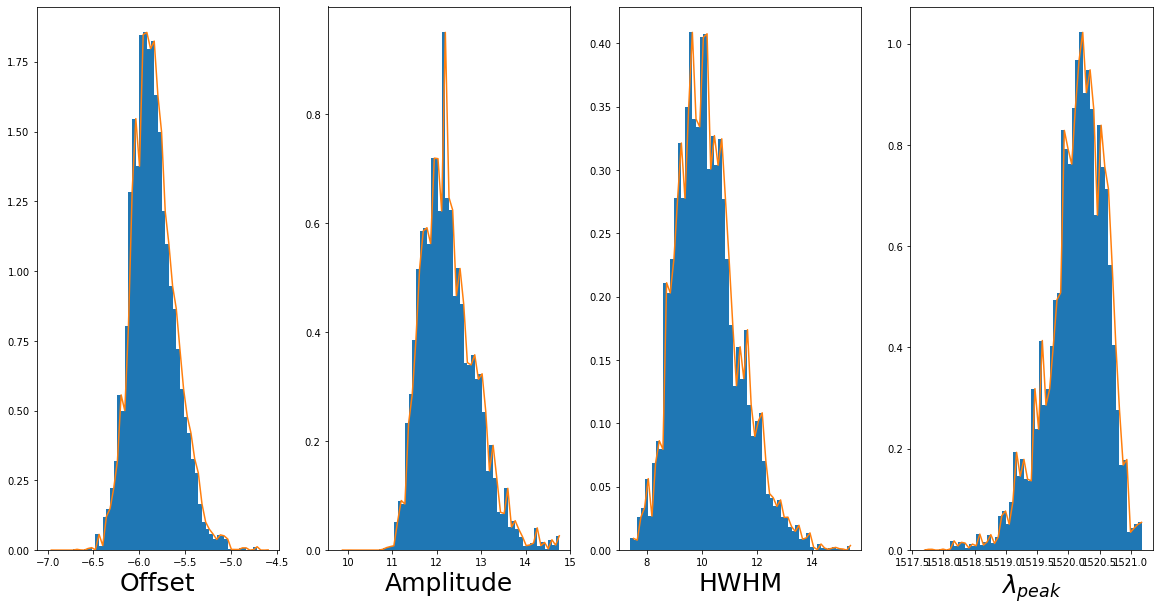

In [29]:
fig2, ax = plt.subplots(1, 4, figsize=(20,10))
xlabel = ['Offset', 'Amplitude', 'HWHM', r'$\lambda_{peak}$']
count = 0
for i in range(len(samples[0])):
    n, bins, patches = ax[i].hist(samples[:,i], bins =60, density = True)
    ax[i].plot(bins[1:],n)
    ax[i].set_xlabel(xlabel[count], fontsize = 25)
    #ax[i].set_ylabel('Counts', fontsize = 25)
    count += 1
    
plt.show()

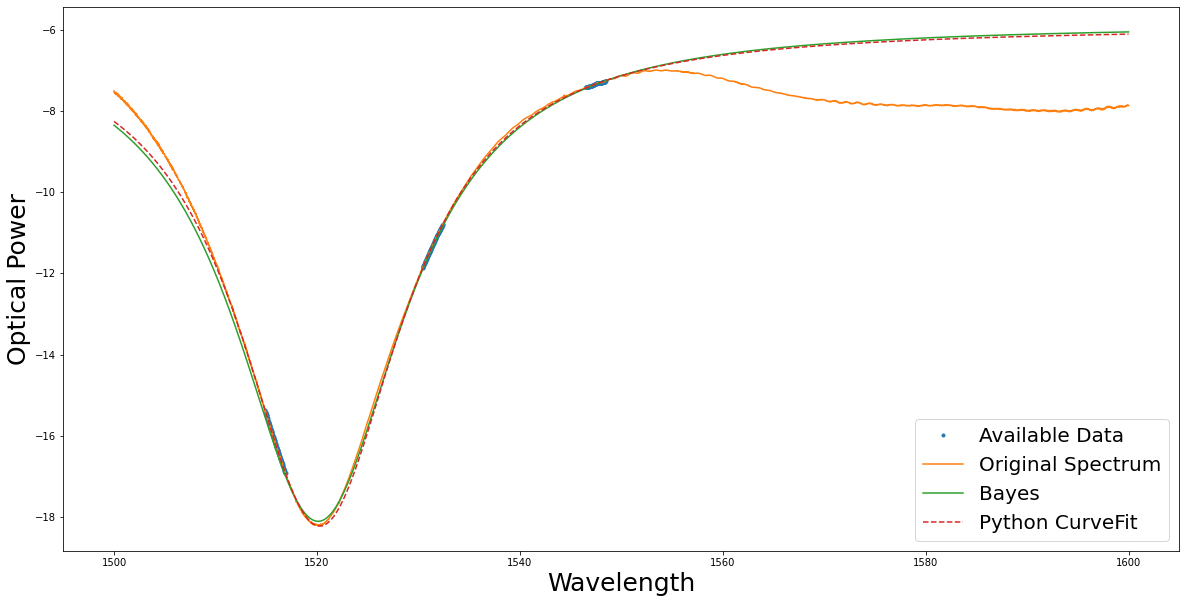

In [30]:
param_bayes = []
for i in range(len(samples[0])):
    param_bayes.append(np.mean(samples[:,i]))
#param[1] = 30    
popt, pcov = opt.curve_fit(L, lamb, data,maxfev = 60000,p0 = param, 
            bounds = limits)
plt.figure(figsize=(20,10))
plt.plot(lamb, data, '.', label = 'Available Data')
plt.plot(lamb_complete, data_complete, label = 'Original Spectrum')
plt.plot(lamb_complete, L(lamb_complete, *param_bayes), label = 'Bayes')
plt.plot(lamb_complete, L(lamb_complete, *popt),'--', label = 'Python CurveFit')
plt.xlabel('Wavelength', fontsize = 25)
plt.ylabel('Optical Power', fontsize = 25)
plt.legend(fontsize = 20)

As we can see, our Bayesian approach gives the same result as the Python Curve Fitting methods, using the same parameters and bounds. This happens because the data obtained from the temperature variation is very well described by the Lorentzian model. This example can serve as an insurance: in the worst case, our method converges to the same answer as the curve fitting methods given the same sets of parameters and limits.

Notice that no priors were used in the Bayesian approach, meaning that with prior knowledge we could have arrived much quickly to a very precise answer.

### Strain Variation Data

We can now do exactly the same tests but in the case of a strain variated LPG. 

**In this case we will incorporate a Gaussian prior for the Amplitude and HWHM parameters** to show how prior knowledge of the LPG's transmission spectrum can imrove our fitting processes. In this case, we set:
$$A \sim N(25,2)$$
$$\gamma \sim N(0.7,0.2)$$

This will prevent our fitting processes from drifting because in the case of this set of data, the Lorentzian model is not as good in describing the spectrum as in the case of the temperature (maybe because of the fabrication of the fiber or the effect that the strain has on the spectrum). The inclusion of the priors will make a clear difference from the normal curve fitting methods and our Bayesian approach.

In [31]:
strain_files = glob.glob("STRAIN_8MAR/*.txt")
ind = np.arange(100, 341, 40)
data_Strain = pd.DataFrame()
data_temp = np.loadtxt(strain_files[0], delimiter = ',',max_rows=3)
data_Strain['Wavelength'] = data_temp[0,1:]
data_Strain['Strain100'] = data_temp[1,1:]
data_Strain.set_index('Wavelength', inplace = True, drop = True) 

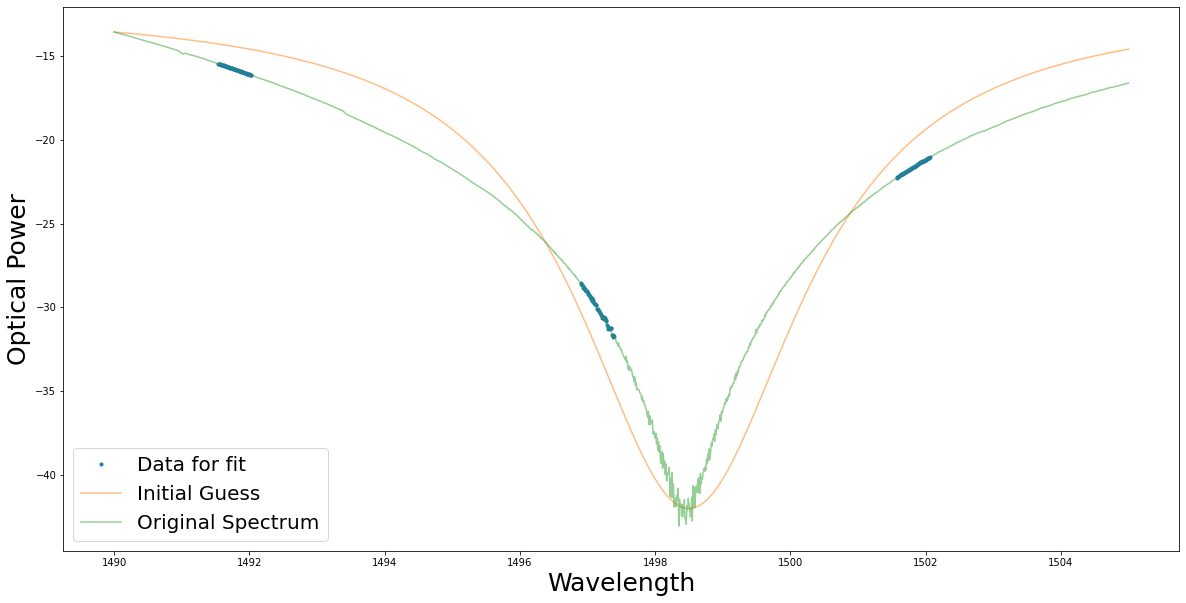

In [81]:
lamb, data, lamb_complete, data_complete = random_sampler(data_Strain, 50)

#Initial Guesses and limits for both methods
param = [-12,30,2,1498.5] #Offset, Amplitude, HWHM, Lambda
limits = [[-15,20,0,1490],[0,40,10,1510]]

plt.figure(figsize=(20,10))
plt.plot(lamb, data, '.', label = 'Data for fit')
plt.plot(lamb_complete, L(lamb_complete, *param),alpha = 0.5, label = 'Initial Guess')
plt.plot(lamb_complete, data_complete,alpha = 0.5, label = 'Original Spectrum')
plt.xlabel('Wavelength', fontsize = 25)
plt.ylabel('Optical Power', fontsize = 25)
plt.legend(fontsize = 20)

In [107]:
sigma = 2
sigma_n = 1
samples = MChain(param, data, 1000000)

10% Done.
20% Done.
30% Done.
40% Done.
50% Done.
60% Done.
70% Done.
80% Done.
90% Done.
100% Done.


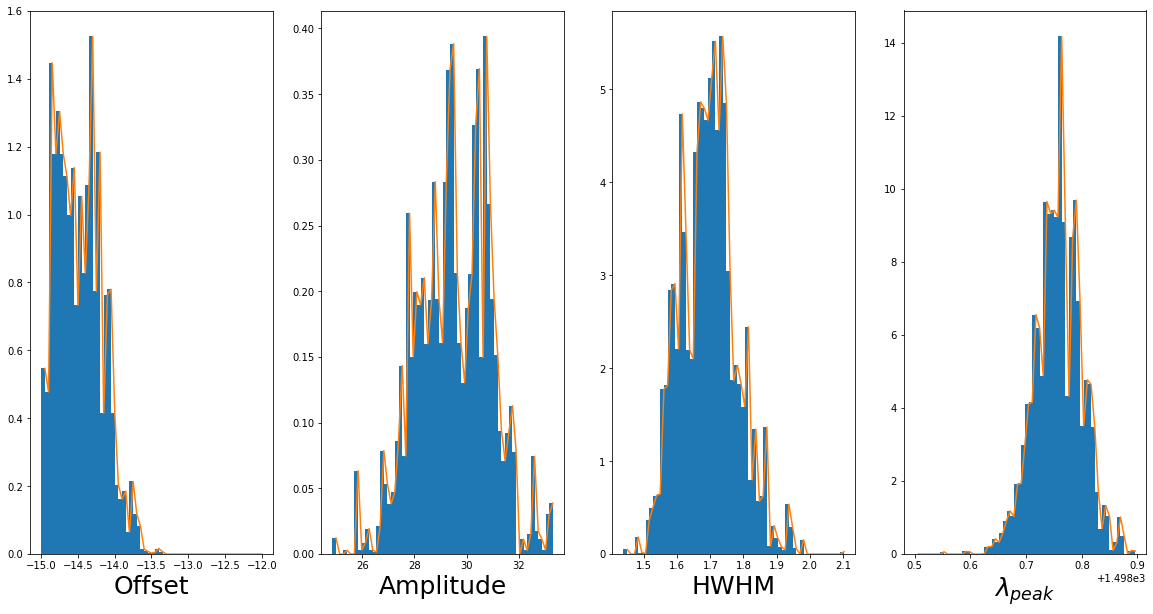

In [110]:
fig2, ax = plt.subplots(1, 4, figsize=(20,10))
xlabel = ['Offset', 'Amplitude', 'HWHM', r'$\lambda_{peak}$']
count = 0
for i in range(len(samples[0])):
    n, bins, patches = ax[i].hist(samples[:,i], bins =60, density = True)
    ax[i].plot(bins[1:],n)
    ax[i].set_xlabel(xlabel[count], fontsize = 25)
    #ax[i].set_ylabel('Counts', fontsize = 25)
    count += 1
    
plt.show()

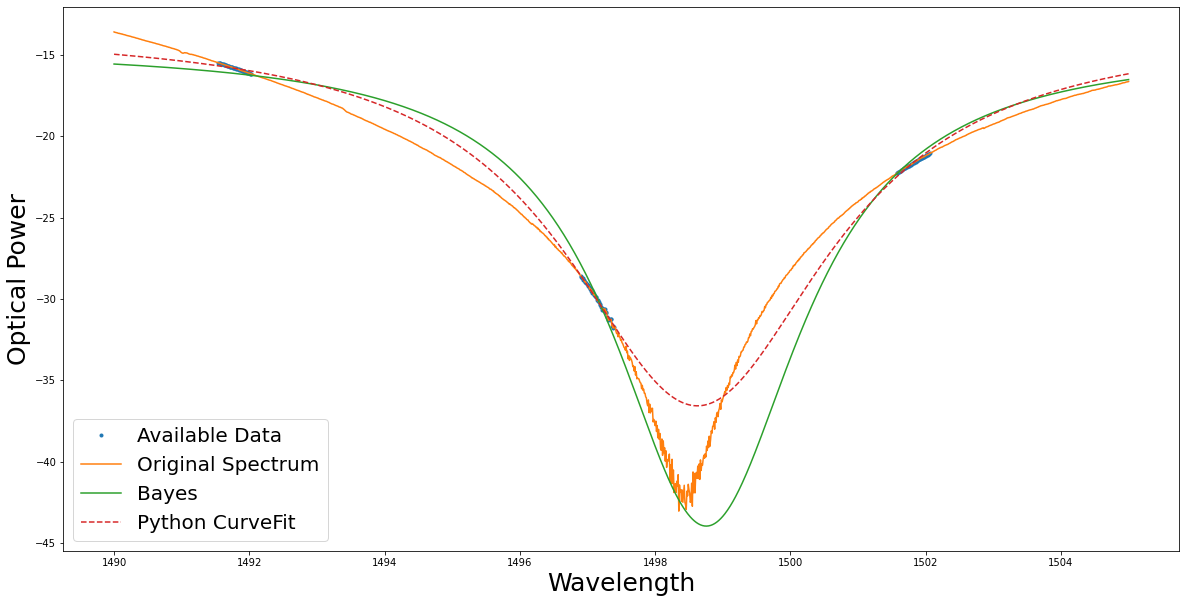

In [111]:
param_bayes = []
for i in range(len(samples[0])):
    param_bayes.append(np.mean(samples[:,i]))
#param[1] = 30    
popt, pcov = opt.curve_fit(L, lamb, data,maxfev = 60000,p0 = param, 
            bounds = limits)
plt.figure(figsize=(20,10))
plt.plot(lamb, data, '.', label = 'Available Data')
plt.plot(lamb_complete, data_complete, label = 'Original Spectrum')
plt.plot(lamb_complete, L(lamb_complete, *param_bayes), label = 'Bayes')
plt.plot(lamb_complete, L(lamb_complete, *popt),'--', label = 'Python CurveFit')
plt.xlabel('Wavelength', fontsize = 25)
plt.ylabel('Optical Power', fontsize = 25)
plt.legend(fontsize = 20)

As we can see, our Bayesian approach gives a better approximation at the original spectrum, which was obtained by establishing some priors provided by previous data, which could be obtained at the moment of the fabrication of the LPG. By further restricting other parameters as the $\lambda_{peak}$ we could have arrived at an even better result.

Notice that in this case where the Lorentzian model does not fit as perfectly to the data, the curve fitting methods show considerable errors, mostly in the amplitude and HWHM parameters.

### Refractive Index Variation Data

We repeat the procedure for a fiber which sufferred external refractive index variation with time. Here our Lorentzian model provides a reasonable fit but some prior fine tuning will also be needed. In this case we will set:
$$A \sim N(28,1)$$
$$\gamma \sim N(2,0.1)$$

In [114]:
RI_files = glob.glob("RI_14MAR/*.txt")
ind = np.arange(0, 10, 1)
data_RI = pd.DataFrame()
data_temp = np.loadtxt(RI_files[3], delimiter = ',',max_rows=3)
data_RI['Wavelength'] = data_temp[0,1:]
data_RI['RI0'] = data_temp[1,1:]
data_RI.set_index('Wavelength', inplace = True, drop = True) 

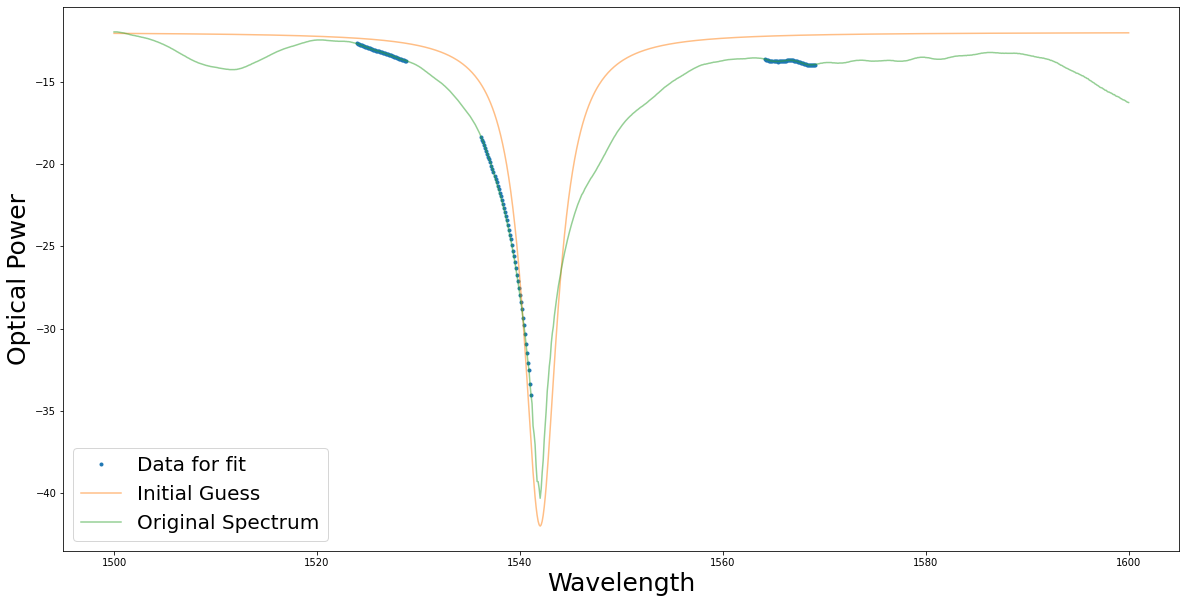

In [115]:
lamb, data, lamb_complete, data_complete = random_sampler(data_RI, 50)

#Initial Guesses and limits for both methods
param = [-12,30,2,1542] #Offset, Amplitude, HWHM, Lambda
limits = [[-18,20,0,1530],[0,40,10,1550]]

plt.figure(figsize=(20,10))
plt.plot(lamb, data, '.', label = 'Data for fit')
plt.plot(lamb_complete, L(lamb_complete, *param),alpha = 0.5, label = 'Initial Guess')
plt.plot(lamb_complete, data_complete,alpha = 0.5, label = 'Original Spectrum')
plt.xlabel('Wavelength', fontsize = 25)
plt.ylabel('Optical Power', fontsize = 25)
plt.legend(fontsize = 20)

In [122]:
sigma = 1
sigma_n = 1
samples = MChain(param, data, 1000000)

10% Done.
20% Done.
30% Done.
40% Done.
50% Done.
60% Done.
70% Done.
80% Done.
90% Done.
100% Done.


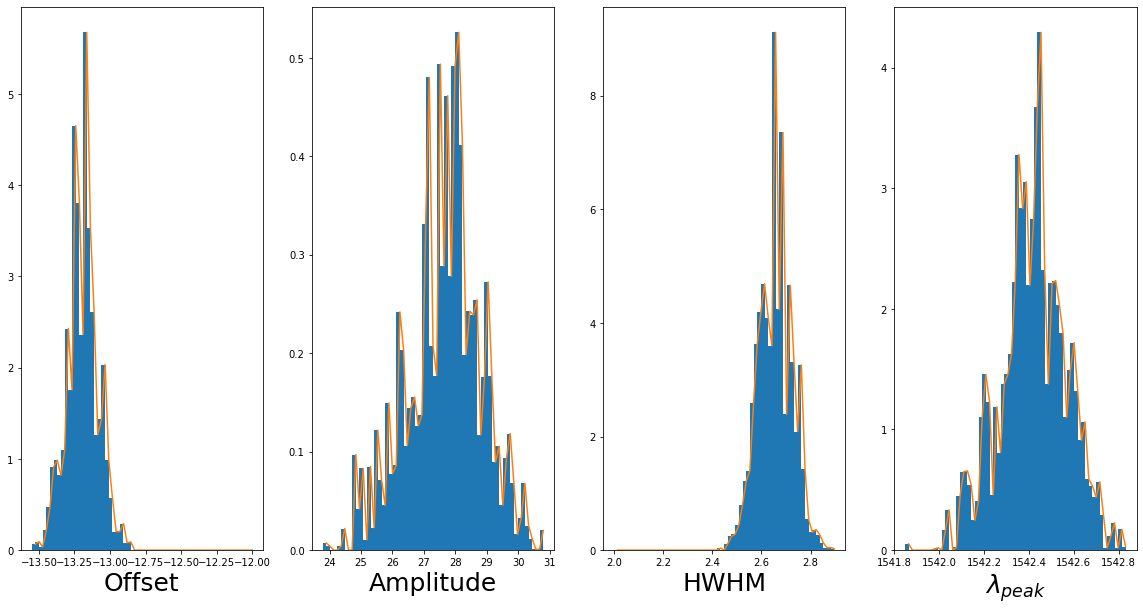

In [123]:
fig2, ax = plt.subplots(1, 4, figsize=(20,10))
xlabel = ['Offset', 'Amplitude', 'HWHM', r'$\lambda_{peak}$']
count = 0
for i in range(len(samples[0])):
    n, bins, patches = ax[i].hist(samples[:,i], bins =60, density = True)
    ax[i].plot(bins[1:],n)
    ax[i].set_xlabel(xlabel[count], fontsize = 25)
    #ax[i].set_ylabel('Counts', fontsize = 25)
    count += 1
    
plt.show()

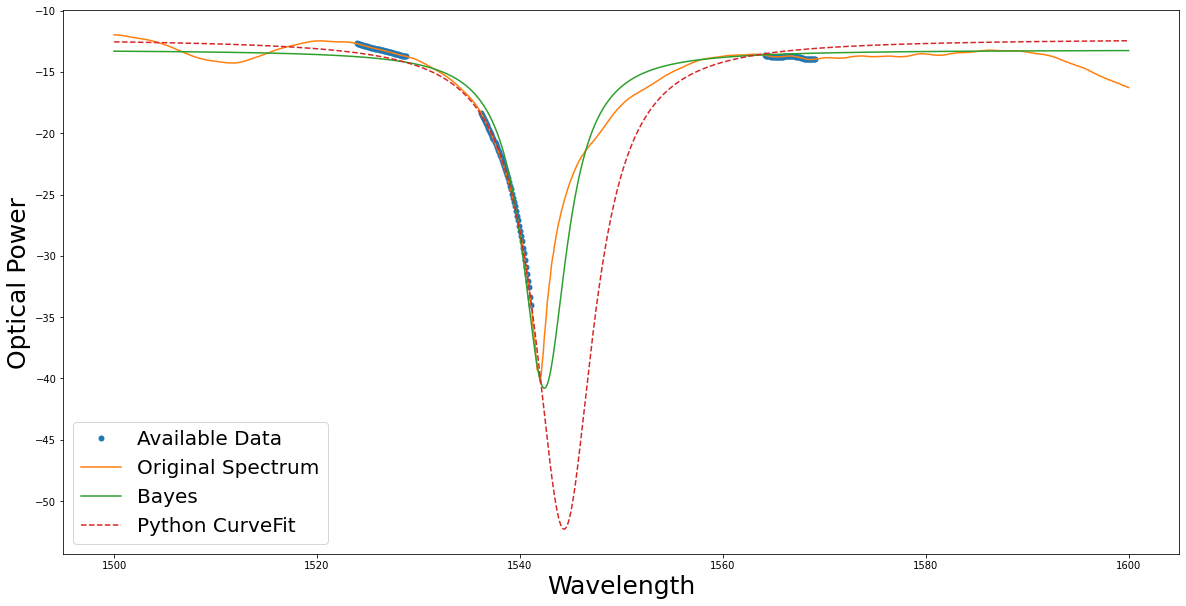

In [126]:
param_bayes = []
for i in range(len(samples[0])):
    param_bayes.append(np.mean(samples[:,i]))
#param[1] = 30    
popt, pcov = opt.curve_fit(L, lamb, data,maxfev = 60000,p0 = param, 
            bounds = limits)
plt.figure(figsize=(20,10))
plt.plot(lamb, data, '.', label = 'Available Data', markersize = 10)
plt.plot(lamb_complete, data_complete, label = 'Original Spectrum')
plt.plot(lamb_complete, L(lamb_complete, *param_bayes), label = 'Bayes')
plt.plot(lamb_complete, L(lamb_complete, *popt),'--', label = 'Python CurveFit')
plt.xlabel('Wavelength', fontsize = 25)
plt.ylabel('Optical Power', fontsize = 25)
plt.legend(fontsize = 20)

Again, our inclusion of non uniform priors allows for a much better fitting to the original spectrum than the conventional curve fitting methods. Obviously it would also be possible to bound these methods further to prevent the parameters such as the amplitude from increasing, but this would also come at the risk of the function not converging at all for a specific solution. Given that we can have very precise previous information from the fabrication and simulation processes in LPG's, the usage of a Bayesian approach seems to fit this particular problem very well.